# Table of Contents

1. Word Embeddings
2. Translation Models

## Install Libraires

In [2]:
# install gensim libraries
!pip install gensim
!pip install google-compute-engine

# afterwards, you need to reinstall python-boto package because of circular installation with google-compute-engine
# sudo apt-get remove python-boto
# sudo apt-get install python-boto

In [1]:
# general libraries
import datetime 
import numpy as np 
import pandas as pd
import re

# model definition
from gensim.models import Word2Vec

# reduce feature sets
from sklearn.decomposition import PCA

# data visualization
from matplotlib import pyplot
%matplotlib inline

# define current time now to be used as saving the model
now = datetime.datetime.now()

In [3]:
# define the region
# also defined in tweets_processor.py but listed here for my own reference
regions_mapping = {
    "albuquerque":0,
    "billings":1,
    "calgary":2,
    "charlotte":3,
    "chicago":4,
    "cincinnati":5,
    "denver":6,
    "houston":7,
    "kansas city":8,
    "las vegas":9,
    "los angeles":10,
    "minneapolis":11,
    "montreal":12,
    "nashville":13,
    "new york":14,
    "oklahoma city":15,
    "phoenix":16,
    "pittsburgh":17,
    "san francisco":18,
    "seattle":19,
    "tampa":20,
    "toronto":21,
    "washington":22
}

# Word Embedding

Word embeddings overcome the many limitations that Bag of Words produced, in particular large sparse vectors that do not describe the meaning of the words. It provides a projection in the vector space where words with similar meanings cluster together. There are two main algorithms used for training the word vectors or Word2Vec: Continuous Bag of Words (CBOW), which predicts the word given its context, and Skip-gram, which predicts the context given the word. We will employ the latter than the former because we have limited training data. Even though CBOW trains several times faster than Skip-gram and is slightly better in terms of accuracy for the frequency of words, it also requires a large text corpus ranging from 1-100B words. 

GloVe is another successful word embedding algorithms with generally better word embeddings because it combines both the global statistics of matrix factorization techniques like LSA with the local context-based learning in Word2Vec. Since we would like the word embeddings to learn from live Twitter feeds, we will stick with Word2Vec as our word embedding used for the translation model later down the line. 


### Notes to self

The problem with word embedding is that you have to know the pair of words in advance.

Also, for classification tasks, fasttext performs faster than word2vec, might want to check this out later.

How to transfer learning and word embeddings:
1. learn word embeddings from large text corpus (1-100B words)
2. Transfer embedding to a new task with smaller training set
3. Continue to finetune word embeddings with new data


### References

* https://www.youtube.com/watch?v=5PL0TmQhItY&t=583s
* using gensim: https://machinelearningmastery.com/what-are-word-embeddings/
* using tensorflow: https://medium.com/deep-math-machine-learning-ai/chapter-9-2-nlp-code-for-word2vec-neural-network-tensorflow-544db99f5334

In [2]:
# retrieve the datasets
df = pd.read_csv("/var/data/tweets_labelled.csv", sep=",")
df.head()

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,text,region
0,does anyone live in the Charleston area and wa...,3
1,You followed my friends to watch me😐,3
2,"Not a totally new subscriber, but just a few d...",20
3,no he doodoo,10
4,Wait that's not an Anime!!,13


In [ ]:
df_40k = pd.read_csv("/var/data/tweets_labelled_40k.csv", sep=",")

## Word embeddings for the entire dataset

In [3]:
# convert each tweet to a list of words
sentences = list()
for sentence in df.text.tolist():
    word_list = re.sub("[^\w]", " ", sentence).split()
    sentences.append(word_list)
sentences[0:5]

[['does',
  'anyone',
  'live',
  'in',
  'the',
  'Charleston',
  'area',
  'and',
  'want',
  'a',
  'job',
  '10',
  'hr',
  'for',
  'Nov',
  '14',
  '21',
  'hmu'],
 ['You', 'followed', 'my', 'friends', 'to', 'watch', 'me'],
 ['Not',
  'a',
  'totally',
  'new',
  'subscriber',
  'but',
  'just',
  'a',
  'few',
  'days',
  'into',
  'it'],
 ['no', 'he', 'doodoo'],
 ['Wait', 'that', 's', 'not', 'an', 'Anime']]

In [4]:
# train the model 
model = Word2Vec(sentences, min_count=1)
model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))
print(model)

Word2Vec(vocab=767446, size=100, alpha=0.025)


In [ ]:
# load the model
# 40k: /var/data/word_embeddings_20181127_054247
# 2.5M: /var/data/word_embeddings_20181127_070749
"""
model = Word2Vec.load('/var/data/word_embeddings_20181127_070749')
"""

In [5]:
# list the words
words = list(model.wv.vocab)
words[0:5]

['does', 'anyone', 'live', 'in', 'the']

/home/divyagorantla/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


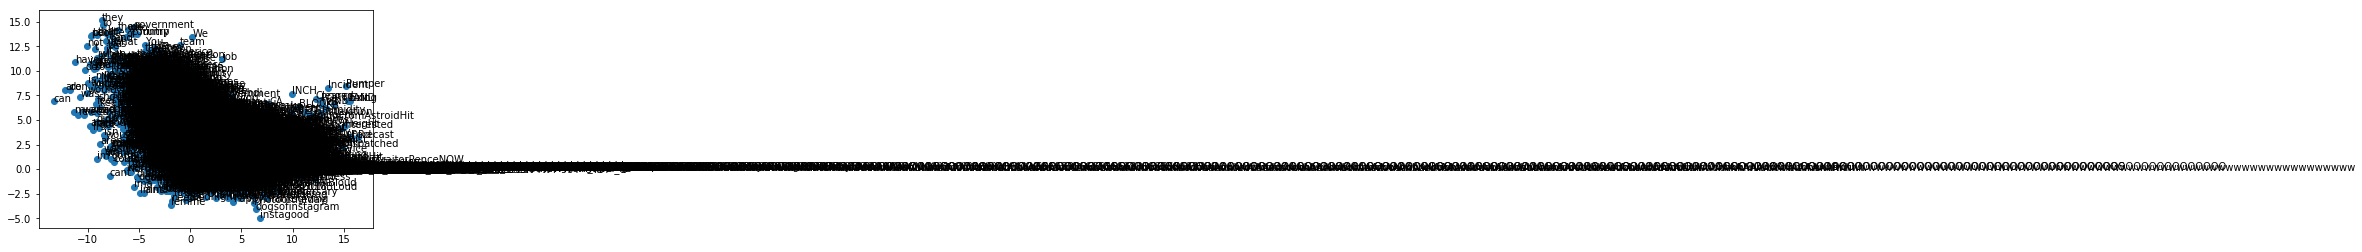

In [6]:
# retrieve all of the vectors from the trained model
x  = model[model.wv.vocab]

# fit a 2D PCA model to the vectors 
pca = PCA(n_components=2)
result = pca.fit_transform(x)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
pyplot.savefig('imgs/word2vec_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

# 2.5M: ~/w266-final/divya-models/word2vec_20181127_070749.png

In [12]:
unique_words = set(words)
len(unique_words)

767446

## Word embeddings for each region

Redo the entire word embeddings done above into an encapsulated function

In [24]:
def plot_word_embeddings(data):
    
    # convert each tweet to a list of words
    sentences = list()
    for sentence in df.text.tolist():
        word_list = re.sub("[^\w]", " ", sentence).split()
        sentences.append(word_list)

    # train the model 
    model = Word2Vec(sentences, min_count=1)
    model.save('/var/models/word_embeddings_{}'.format(now.strftime('%Y%m%d_%H%M%S')))

    # list the words
    words = list(model.wv.vocab)

    # retrieve all of the vectors from the trained model
    x  = model[model.wv.vocab]

    # fit a 2D PCA model to the vectors 
    pca = PCA(n_components=2)
    result = pca.fit_transform(x)
    pyplot.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
    pyplot.show()

# Character Word Model

pro: character word model does not have to worry about unknown word token
cons: not good at capturing how the early parts of the sentence affects the later part of the sentence, also computationally expensive to train

good use case for specialized vocabulary and lots of unknown words
